Algorithm:






Base Code

In [124]:
import numpy as np
import matplotlib.pyplot as plt

class Parameters:   #class for defining parameters

    '''
Parameters defined as one class

A paramter instance is created for a specific paramter combination which is used by the simulation function'''

    def __init__(self, b1, b2, k1, k2, c12, c21, z_m1_initial, z_m2_initial, initial_population_species_1, initial_population_species_2, cost_to_males, strength_of_interference, V_A1, V_A2, num_generations):
        self.b1 = b1    #growth rate of sp. 1
        self.b2 = b2    #growth rate of sp. 2
        self.k1 = k1    #density dependent mortality of sp. 1
        self.k2 = k2    #density dependent mortality of sp. 2
        self.c12 = c12  #competetive effect of sp. 2 on sp. 1
        self.c21 = c21  #competetive effect of sp. 1 on sp. 2
        self.z_m1_initial = z_m1_initial  #initial mean discrimination of males of sp.1
        self.z_m2_initial = z_m2_initial  #initial mean discriminatiin of males of sp. 2
        self.initial_population_species_1 = initial_population_species_1  
        self.initial_population_species_2 = initial_population_species_2
        self.cost_to_males = cost_to_males   #cost of wrong matings for male fitness
        self.strength_of_interference = strength_of_interference  #how heterospecific matings affect fitness
        self.V_A1 = V_A1  #evolvabilty i.e. additive genetic variance of sp.1
        self.V_A2 = V_A2  #evolvabilty i.e. additive genetic variance of sp.2
        self.num_generations = num_generations  

class Simulation:

    '''Simulation defined as the other class which takes the parameter instance as an argument and runs the simulation. '''


    '''initial population of the species and initual trait values are recorded. Lists are created, which will store the population and trait values for each generation.'''
    def __init__(self, params):
        self.params = params
        self.population_species_history_1 = [params.initial_population_species_1]
        self.population_species_history_2 = [params.initial_population_species_2]
        self.z_m1_history = [params.z_m1_initial]
        self.z_m2_history = [params.z_m2_initial]
        self.z_m1 = params.z_m1_initial
        self.z_m2 = params.z_m2_initial


    def next_generation_ecology(self):
        '''function to calculate next generatioin pop numbers for both species using current population numbers and trait values. The new population numbers are calculated using the ecological equations given in the paper. The new population numbers are appended to the population history list.'''

    

        '''N1 and N2 are taken as the population of the species at the current generation.  (thus, last entry of the population history list)'''
        N1 = self.population_species_history_1[-1]
        N2 = self.population_species_history_2[-1]

        
        if N1 > 0:  #only if N1 > 0 is there a chance of there being population change. else the population continues to be 0
            next_N1 = self.params.b1 * (N1 / 2) * (N1 / (N1 + self.params.strength_of_interference * (1 - self.z_m2) * N2)) - (self.params.k1 * N1 * (N1 + self.params.c12 * N2))
            next_N1 = max(next_N1, 0)   #to ensure that next_N1 is not negative 
        else:
            next_N1 = 0 
        
        if N2 > 0:
            next_N2 = self.params.b2 * (N2 / 2) * (N2 / (N2 + self.params.strength_of_interference * (1 - self.z_m1) * N1)) - (self.params.k2 * N2 * (N2 + self.params.c21 * N1))
            next_N2 = max(next_N2, 0)   #to ensure that next_N2 is not negative
        else:
            next_N2 = 0

        self.population_species_history_1.append(next_N1)   #append next generation population numbers to the population history list
        self.population_species_history_2.append(next_N2)

    def next_generation_traits(self, N1, N2):
        if N1 > 0:  #only if both species have non zero population numbers, there is evolution of trait values. Else the trait values remain the same as the previous generation.
            W_m1 = 1 - (self.params.cost_to_males * (1 - self.z_m1) * (N2 / (N2 + N1)))   # ''Fitness'' of trait z_m1. fitness cost to mating, times proportion of incorrect matings
            
            dW_m1_dz_m2 = self.params.cost_to_males * (N2 / (N2 + N1)) #dw_m1/dz_m2 is the derivative of fitness with respect to the trait value of the species.
            
            delta_z_m1 = self.params.V_A1 * (1 / W_m1) * dW_m1_dz_m2  #change in trait value of species 1. Additive genetic variance x 1/W x w
            new_z_m1 = self.z_m1 + delta_z_m1
            
            if new_z_m1 <= 1:
                self.z_m1 = new_z_m1

            self.z_m1_history.append(self.z_m1)

        if N2 > 0: 

            W_m2 = 1 - (self.params.cost_to_males * (1 - self.z_m2) * (N2 / (N2 + N1)))
            dW_m2_dz_m2 = self.params.cost_to_males * (N1 / (N1 + N2))
            delta_z_m2 = self.params.V_A2 * (1 / W_m2) * dW_m2_dz_m2
            new_z_m2 = self.z_m2 + delta_z_m2
            if new_z_m2 <= 1:
                self.z_m2 = new_z_m2

            self.z_m2_history.append(self.z_m2)

    def next_generation(self):
        '''next generation ecology (population numbers) and evolution (trait updation). There is seperation of time scales'''
        self.next_generation_ecology()   #calculate and update the population numbers for the next 
        
        '''Evolution - trait updation'''
        N1 = self.population_species_history_1[-1]  #from the list take the last entry which is the population number for the next generation
        N2 = self.population_species_history_2[-1]   
        self.next_generation_traits(N1, N2)  #using the new population numbers can 
        return N1, N2

    def run_simulation(self):   
        for t in range(self.params.num_generations - 1):
            N1, N2 = self.next_generation()    #run the next generation function for each generation
            if N1 == 0 or N2 == 0:    #if either of the species goes extinct, the simulation stops
                print(f"At generation {t + 1}, one of the species went extinct.")
                break
        return self.population_species_history_1, self.population_species_history_2, self.z_m1_history, self.z_m2_history

class Plotter:
    @staticmethod
    def plot_population_dynamics(population_species_1, population_species_2):
        plt.ion()  # Turn on interactive mode
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(population_species_1, label='Species 1')
        ax.plot(population_species_2, label='Species 2')
        ax.set_xlabel('Time')
        ax.set_ylabel('Population')
        ax.set_title('Population Dynamics of Two Competing Species')
        ax.legend()
        ax.grid(True)
        plt.show()

    @staticmethod
    def plot_traits_evolution(z_m1_history, z_m2_history):
        plt.ion()  # Turn on interactive mode
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(z_m1_history, label="Mean Trait z_m1")
        ax.plot(z_m2_history, label="Mean Trait z_m2")
        ax.set_xlabel("Generation")
        ax.set_ylabel("Mean Trait Value")
        ax.set_title('Evolution of Traits')
        ax.legend()
        ax.grid(True)
        plt.show()


Base Parameters Simulation

At generation 38, one of the species went extinct.


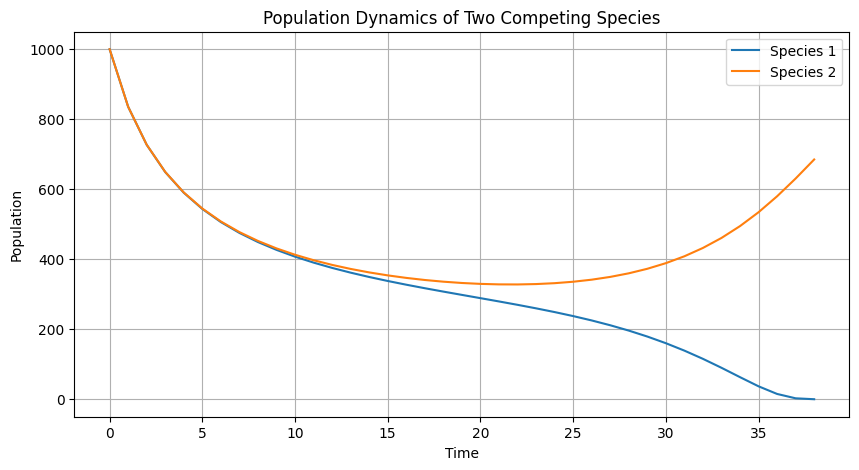

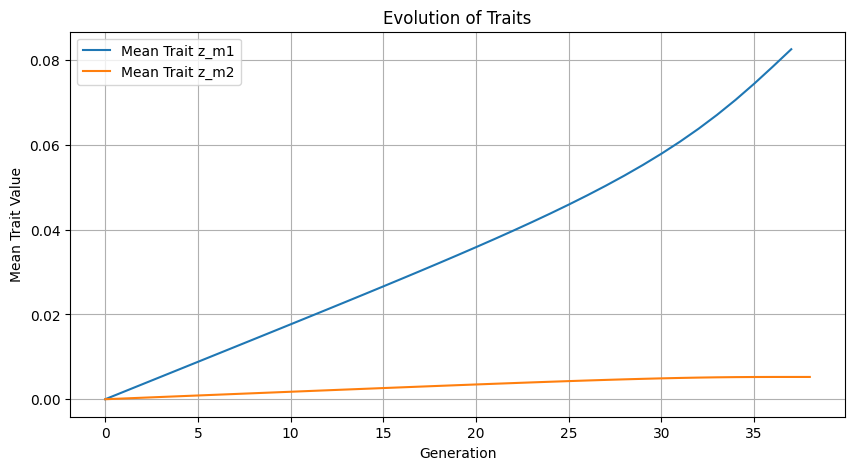

Final mean trait z_m1: 0.08253924547631473
Final mean trait z_m2: 0.005251534221876526


In [128]:

# Parameters
base_parameters = Parameters(
    b1 = 2.3, 
    b2 = 2.3, 
    k1 = 0.0001, 
    k2 = 0.0001, 
    c12 = 1.1, 
    c21 = 1.1, 
    z_m1_initial = 0, 
    z_m2_initial = 0, 
    initial_population_species_1 = 1000, 
    initial_population_species_2 = 1000, 
    cost_to_males = 0.3,
    strength_of_interference = 0.1,
    V_A1 = 0.01, 
    V_A2 = 0.001, 
    num_generations = 10000
)


# Simulation
sim = Simulation(base_parameters)
population_species_1, population_species_2, z_m1_history, z_m2_history = sim.run_simulation()

# Plotting
Plotter.plot_population_dynamics(population_species_1, population_species_2)
Plotter.plot_traits_evolution(z_m1_history, z_m2_history)

print("Final mean trait z_m1:", sim.z_m1)
print("Final mean trait z_m2:", sim.z_m2)


Sensitivity Analysis


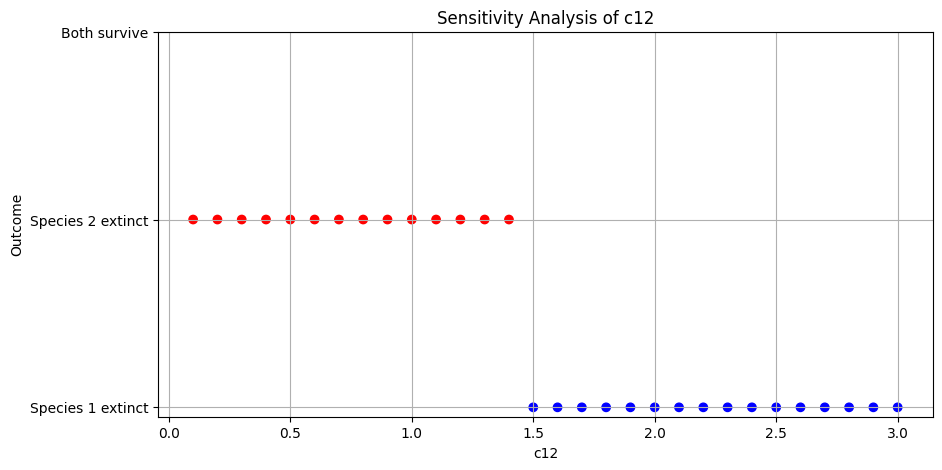

In [55]:
import numpy as np
import matplotlib.pyplot as plt

class Parameters:
    def __init__(self, b1, b2, k1, k2, c12, c21, z_m1_initial, z_m2_initial, initial_population_species_1, initial_population_species_2, cost_to_males, strength_of_interference, V_A1, V_A2, num_generations):
        self.b1 = b1
        self.b2 = b2
        self.k1 = k1
        self.k2 = k2
        self.c12 = c12
        self.c21 = c21
        self.z_m1_initial = z_m1_initial
        self.z_m2_initial = z_m2_initial
        self.initial_population_species_1 = initial_population_species_1
        self.initial_population_species_2 = initial_population_species_2
        self.cost_to_males = cost_to_males
        self.strength_of_interference = strength_of_interference
        self.V_A1 = V_A1
        self.V_A2 = V_A2
        self.num_generations = num_generations

class Simulation:
    def __init__(self, params):
        self.params = params
        self.population_species_history_1 = [params.initial_population_species_1]
        self.population_species_history_2 = [params.initial_population_species_2]
        self.z_m1_history = [params.z_m1_initial]
        self.z_m2_history = [params.z_m2_initial]
        self.z_m1 = params.z_m1_initial
        self.z_m2 = params.z_m2_initial

    def next_generation_ecology(self):
        N1 = self.population_species_history_1[-1]
        N2 = self.population_species_history_2[-1]

        if N1 > 0:
            next_N1 = self.params.b1 * (N1 / 2) * (N1 / (N1 + self.params.strength_of_interference * (1 - self.z_m2) * N2)) - (self.params.k1 * N1 * (N1 + self.params.c12 * N2))
            next_N1 = max(next_N1, 0)
        else:
            next_N1 = 0

        if N2 > 0:
            next_N2 = self.params.b2 * (N2 / 2) * (N2 / (N2 + self.params.strength_of_interference * (1 - self.z_m1) * N1)) - (self.params.k2 * N2 * (N2 + self.params.c21 * N1))
            next_N2 = max(next_N2, 0)
        else:
            next_N2 = 0

        self.population_species_history_1.append(next_N1)
        self.population_species_history_2.append(next_N2)

    def next_generation_traits(self, N1, N2):
        if N1 > 0:
            W_m1 = 1 - (self.params.cost_to_males * (1 - self.z_m1) * (N2 / (N2 + N1)))
            dW_m1_dz_m2 = self.params.cost_to_males * (N2 / (N2 + N1))
            delta_z_m1 = self.params.V_A1 * (1 / W_m1) * dW_m1_dz_m2
            new_z_m1 = self.z_m1 + delta_z_m1

            if new_z_m1 <= 1:
                self.z_m1 = new_z_m1

            self.z_m1_history.append(self.z_m1)

        if N2 > 0:
            W_m2 = 1 - (self.params.cost_to_males * (1 - self.z_m2) * (N2 / (N2 + N1)))
            dW_m2_dz_m2 = self.params.cost_to_males * (N1 / (N1 + N2))
            delta_z_m2 = self.params.V_A2 * (1 / W_m2) * dW_m2_dz_m2
            new_z_m2 = self.z_m2 + delta_z_m2
            if new_z_m2 <= 1:
                self.z_m2 = new_z_m2

            self.z_m2_history.append(self.z_m2)

    def next_generation(self):
        self.next_generation_ecology()
        N1 = self.population_species_history_1[-1]
        N2 = self.population_species_history_2[-1]
        self.next_generation_traits(N1, N2)
        return N1, N2

    def run_simulation(self):   
        for t in range(self.params.num_generations - 1):
            N1, N2 = self.next_generation()
            if N1 == 0 or N2 == 0:
                break

        outcome = 2  # Both species survive
        if N1 == 0:
            outcome = 0  # Species 1 went extinct
        elif N2 == 0:
            outcome = 1  # Species 2 went extinct

        return self.population_species_history_1, self.population_species_history_2, self.z_m1_history, self.z_m2_history, outcome

class Plotter:
    @staticmethod
    def plot_population_dynamics(population_species_1, population_species_2):
        plt.figure(figsize=(10, 5))
        plt.plot(population_species_1, label='Species 1')
        plt.plot(population_species_2, label='Species 2')
        plt.xlabel('Time')
        plt.ylabel('Population')
        plt.title('Population Dynamics of Two Competing Species')
        plt.legend()
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_traits_evolution(z_m1_history, z_m2_history):
        plt.figure(figsize=(10, 5))
        plt.plot(z_m1_history, label="Mean Trait z_m1")
        plt.plot(z_m2_history, label="Mean Trait z_m2")
        plt.xlabel("Generation")
        plt.ylabel("Mean Trait Value")
        plt.title('Evolution of Traits')
        plt.legend()
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_sensitivity_analysis(c12_values, outcomes):
        color_map = {0: 'blue', 1: 'red', 2: 'green'}
        colors = [color_map[outcome] for outcome in outcomes]
        
        plt.figure(figsize=(10, 5))
        plt.scatter(c12_values, outcomes, color=colors, marker='o')
        plt.xlabel('c12')
        plt.ylabel('Outcome')
        plt.title('Sensitivity Analysis of c12')
        plt.yticks([0, 1, 2], ['Species 1 extinct', 'Species 2 extinct', 'Both survive'])
        plt.grid(True)
        plt.show()

def generate_parameters_with_c12(base_params, c12_values):
    params_list = []
    for c12 in c12_values:
        params = Parameters(
            b1=base_params.b1,
            b2=base_params.b2,
            k1=base_params.k1,
            k2=base_params.k2,
            c12=c12,
            c21=base_params.c21,
            z_m1_initial=base_params.z_m1_initial,
            z_m2_initial=base_params.z_m2_initial,
            initial_population_species_1=base_params.initial_population_species_1,
            initial_population_species_2=base_params.initial_population_species_2,
            cost_to_males=base_params.cost_to_males,
            strength_of_interference=base_params.strength_of_interference,
            V_A1=base_params.V_A1,
            V_A2=base_params.V_A2,
            num_generations=base_params.num_generations
        )
        params_list.append(params)
    return params_list

def run_sensitivity_analysis(params_list):
    outcomes = []
    for params in params_list:
        sim = Simulation(params)
        _, _, _, _, outcome = sim.run_simulation()
        outcomes.append(outcome)
    return outcomes

def main():
    # Base Parameters
    base_params = Parameters(
        b1 = 2.5, 
        b2 = 2.5, 
        k1 = 0.0001, 
        k2 = 0.0001, 
        c12 = 1.5, 
        c21 = 1, 
        z_m1_initial = 0.5, 
        z_m2_initial = 0.5, 
        initial_population_species_1 = 10, 
        initial_population_species_2 = 10, 
        cost_to_males = 0.1,
        strength_of_interference = 0.5,
        V_A1 = 0.001, 
        V_A2 = 0.01, 
        num_generations = 1000
    )

    # Sensitivity Analysis for c12
    c12_values = np.linspace(0.1, 3, 30)
    params_list = generate_parameters_with_c12(base_params, c12_values)
    outcomes = run_sensitivity_analysis(params_list)
    Plotter.plot_sensitivity_analysis(c12_values, outcomes)

if __name__ == "__main__":
    main()


Running sensitivity analysis for b1...


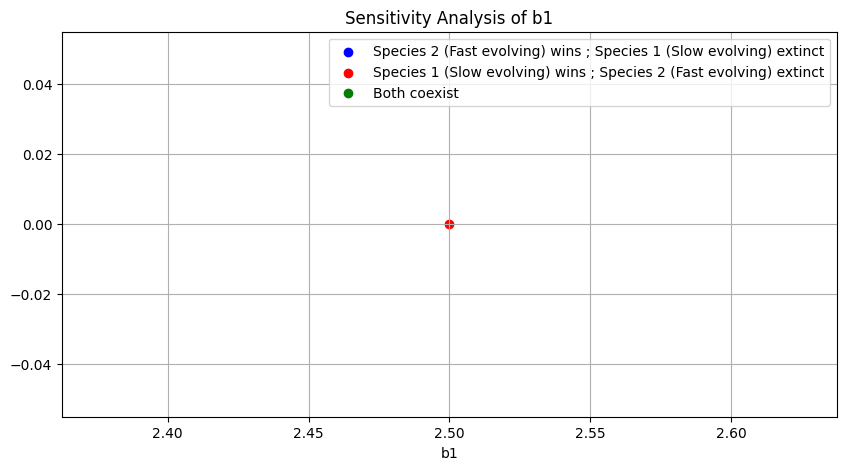

Running sensitivity analysis for b2...


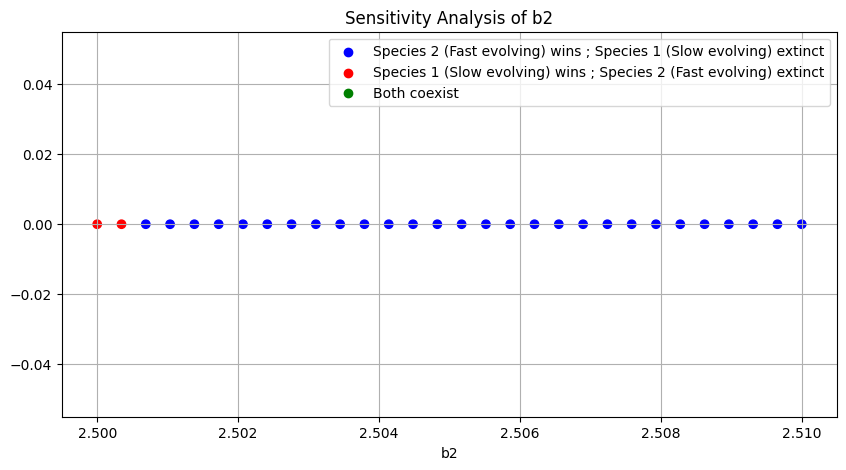

Running sensitivity analysis for k1...


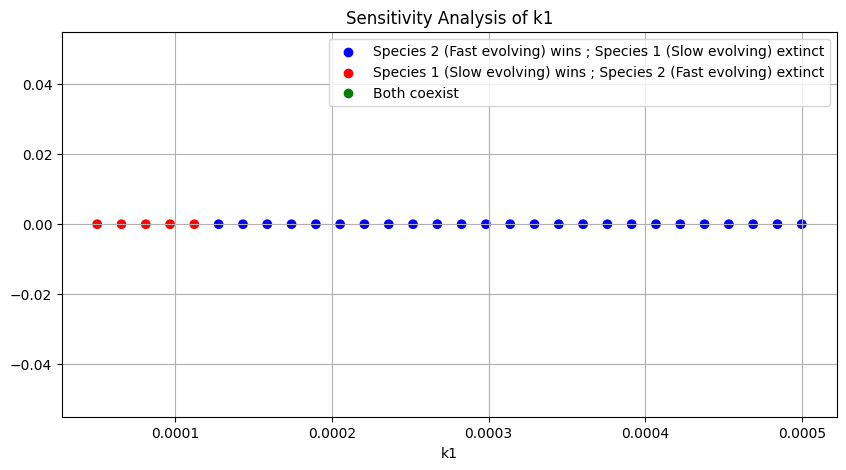

Running sensitivity analysis for k2...


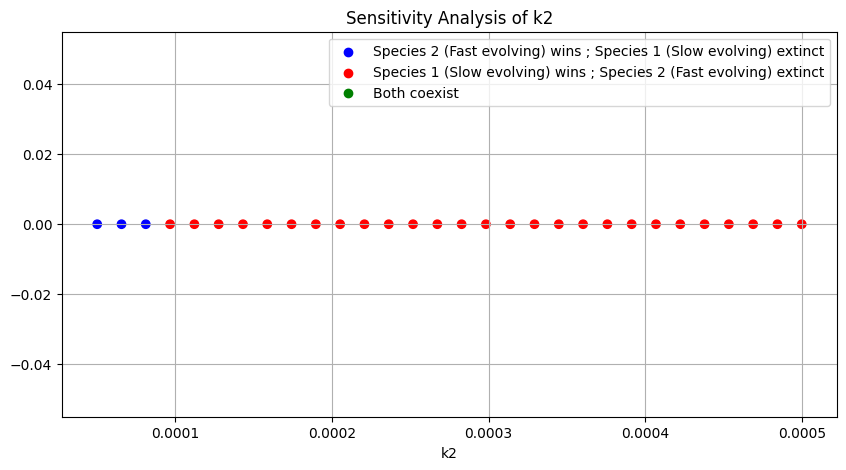

Running sensitivity analysis for c12...


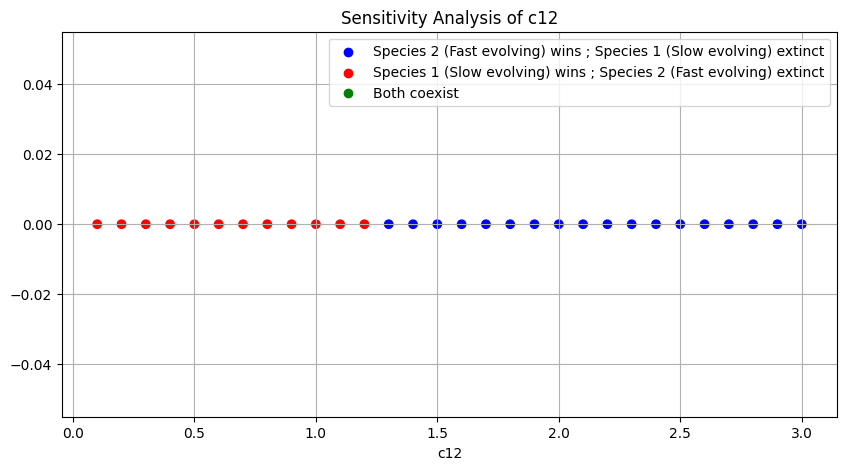

Running sensitivity analysis for c21...


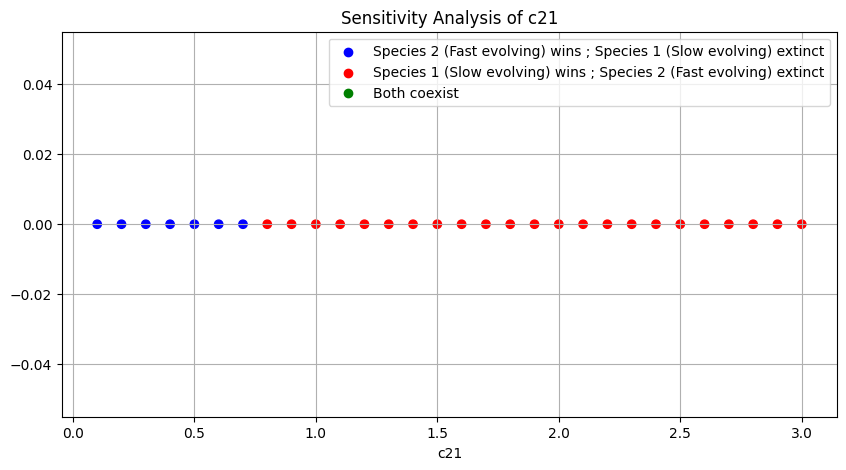

Running sensitivity analysis for z_m1_initial...


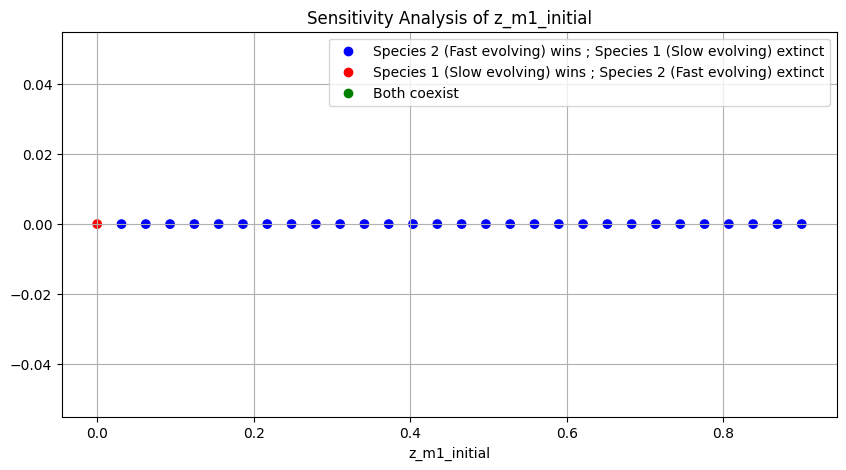

Running sensitivity analysis for z_m2_initial...


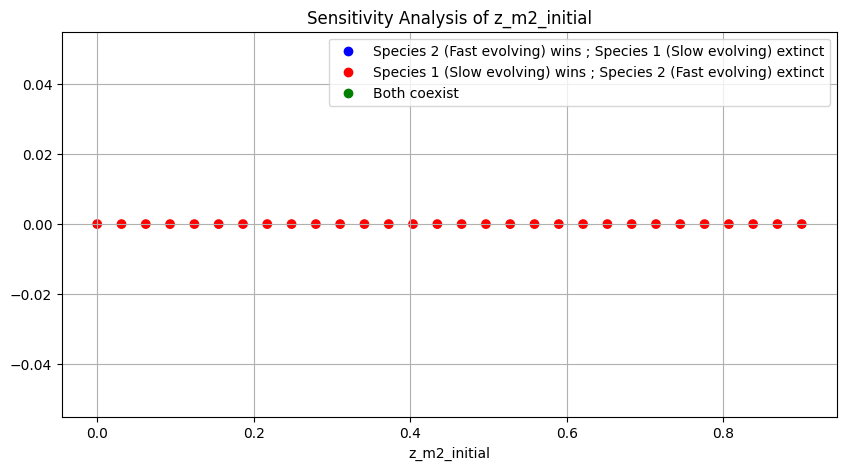

Running sensitivity analysis for cost_to_males...


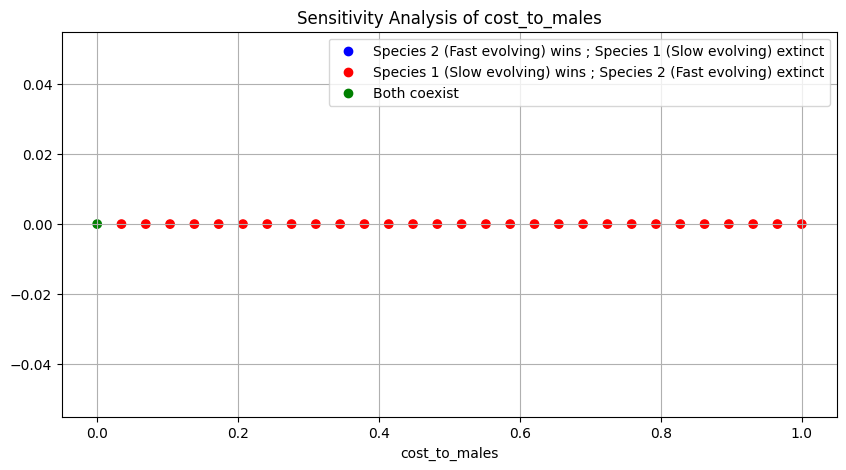

Running sensitivity analysis for strength_of_interference...


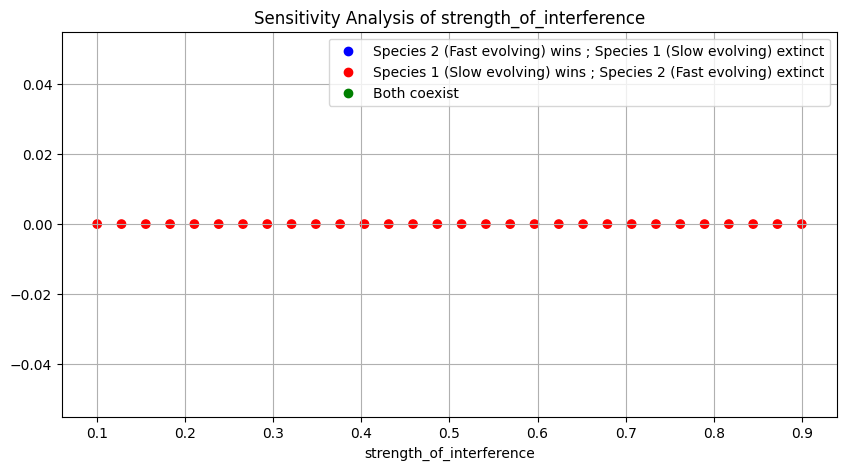

Running sensitivity analysis for V_A1...


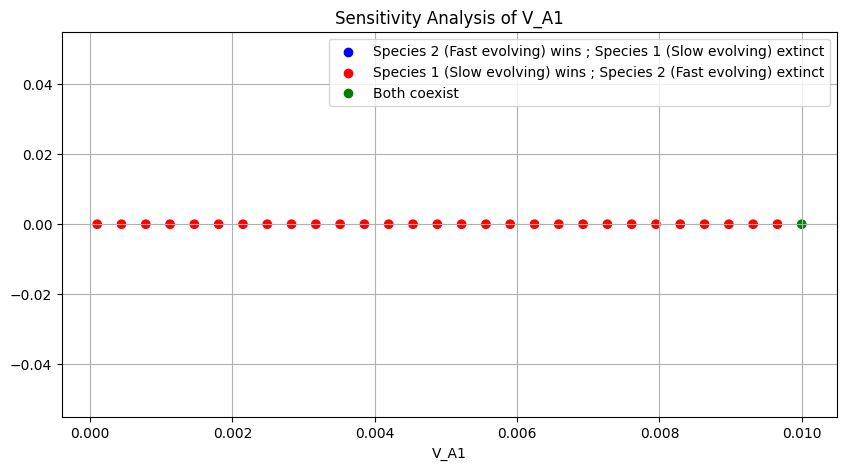

Running sensitivity analysis for V_A2...


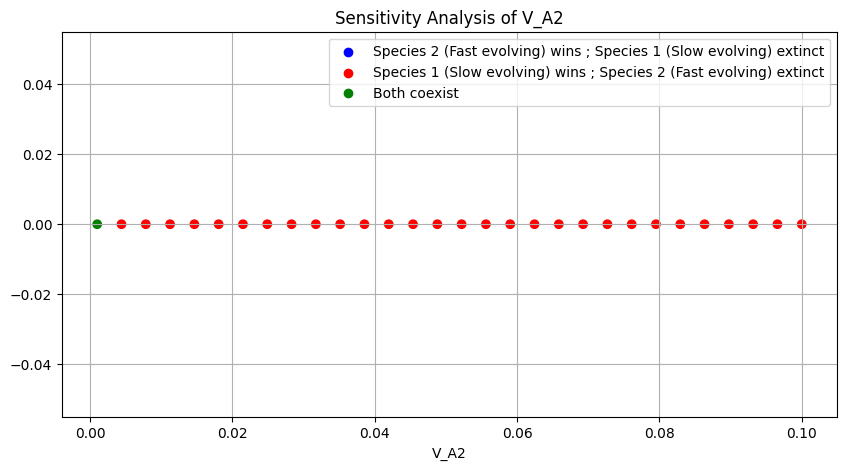

In [119]:
import numpy as np
import matplotlib.pyplot as plt

class Parameters:
    def __init__(self, **kwargs):
        self.b1 = kwargs.get('b1', 2.5)
        self.b2 = kwargs.get('b2', 2.5)
        self.k1 = kwargs.get('k1', 0.0001)
        self.k2 = kwargs.get('k2', 0.0001)
        self.c12 = kwargs.get('c12', 1)
        self.c21 = kwargs.get('c21', 1)
        self.z_m1_initial = kwargs.get('z_m1_initial', 0.5)
        self.z_m2_initial = kwargs.get('z_m2_initial', 0.5)
        self.initial_population_species_1 = kwargs.get('initial_population_species_1', 10)
        self.initial_population_species_2 = kwargs.get('initial_population_species_2', 10)
        self.cost_to_males = kwargs.get('cost_to_males', 0.1)
        self.strength_of_interference = kwargs.get('strength_of_interference', 0.5)
        self.V_A1 = kwargs.get('V_A1', 0.001)
        self.V_A2 = kwargs.get('V_A2', 0.01)
        self.num_generations = kwargs.get('num_generations', 1000)

class Simulation:
    def __init__(self, params):
        self.params = params
        self.population_species_history_1 = [params.initial_population_species_1]
        self.population_species_history_2 = [params.initial_population_species_2]
        self.z_m1_history = [params.z_m1_initial]
        self.z_m2_history = [params.z_m2_initial]
        self.z_m1 = params.z_m1_initial
        self.z_m2 = params.z_m2_initial

    def next_generation_ecology(self):
        N1 = self.population_species_history_1[-1]
        N2 = self.population_species_history_2[-1]

        if N1 > 0:
            next_N1 = self.params.b1 * (N1 / 2) * (N1 / (N1 + self.params.strength_of_interference * (1 - self.z_m2) * N2)) - (self.params.k1 * N1 * (N1 + self.params.c12 * N2))
            next_N1 = max(next_N1, 0)
        else:
            next_N1 = 0

        if N2 > 0:
            next_N2 = self.params.b2 * (N2 / 2) * (N2 / (N2 + self.params.strength_of_interference * (1 - self.z_m1) * N1)) - (self.params.k2 * N2 * (N2 + self.params.c21 * N1))
            next_N2 = max(next_N2, 0)
        else:
            next_N2 = 0

        self.population_species_history_1.append(next_N1)
        self.population_species_history_2.append(next_N2)

    def next_generation_traits(self, N1, N2):
        if N1 > 0:
            W_m1 = 1 - (self.params.cost_to_males * (1 - self.z_m1) * (N2 / (N2 + N1)))
            dW_m1_dz_m2 = self.params.cost_to_males * (N2 / (N2 + N1))
            delta_z_m1 = self.params.V_A1 * (1 / W_m1) * dW_m1_dz_m2
            new_z_m1 = self.z_m1 + delta_z_m1

            if new_z_m1 <= 1:
                self.z_m1 = new_z_m1

            self.z_m1_history.append(self.z_m1)

        if N2 > 0:
            W_m2 = 1 - (self.params.cost_to_males * (1 - self.z_m2) * (N2 / (N2 + N1)))
            dW_m2_dz_m2 = self.params.cost_to_males * (N1 / (N1 + N2))
            delta_z_m2 = self.params.V_A2 * (1 / W_m2) * dW_m2_dz_m2
            new_z_m2 = self.z_m2 + delta_z_m2
            if new_z_m2 <= 1:
                self.z_m2 = new_z_m2

            self.z_m2_history.append(self.z_m2)

    def next_generation(self):
        self.next_generation_ecology()
        N1 = self.population_species_history_1[-1]
        N2 = self.population_species_history_2[-1]
        self.next_generation_traits(N1, N2)
        return N1, N2

    def run_simulation(self):   
        for t in range(self.params.num_generations - 1):
            N1, N2 = self.next_generation()
            if N1 == 0 or N2 == 0:
                break

        outcome = 2  # Both species survive
        if N1 == 0:
            outcome = 0  # Species 1 went extinct
        elif N2 == 0:
            outcome = 1  # Species 2 went extinct

        return self.population_species_history_1, self.population_species_history_2, self.z_m1_history, self.z_m2_history, outcome

class Plotter:
    @staticmethod
    def plot_population_dynamics(population_species_1, population_species_2):
        plt.figure(figsize=(10, 5))
        plt.plot(population_species_1, label='Species 1')
        plt.plot(population_species_2, label='Species 2')
        plt.xlabel('Time')
        plt.ylabel('Population')
        plt.title('Population Dynamics of Two Competing Species')
        plt.legend()
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_traits_evolution(z_m1_history, z_m2_history):
        plt.figure(figsize=(10, 5))
        plt.plot(z_m1_history, label="Mean Trait z_m1")
        plt.plot(z_m2_history, label="Mean Trait z_m2")
        plt.xlabel("Generation")
        plt.ylabel("Mean Trait Value")
        plt.title('Evolution of Traits')
        plt.legend()
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_sensitivity_analysis(param_values, outcomes, param_name):
        color_map = {0: 'blue', 1: 'red', 2: 'green'}
        colors = [color_map[outcome] for outcome in outcomes]
        
        plt.figure(figsize=(10, 5))
        plt.scatter(param_values, [0]*len(param_values), color=colors, marker='o')
        plt.xlabel(param_name)
        plt.title(f'Sensitivity Analysis of {param_name}')
        plt.grid(True)
        # Adding legend manually
        plt.scatter([], [], color='blue', label='Species 2 (Fast evolving) wins ; Species 1 (Slow evolving) extinct')
        plt.scatter([], [], color='red', label='Species 1 (Slow evolving) wins ; Species 2 (Fast evolving) extinct')
        plt.scatter([], [], color='green', label='Both coexist')
        plt.legend(loc='upper right')
        plt.show()

def generate_parameters_with_varied_param(base_params, param_name, param_values):
    params_list = []
    for value in param_values:
        params_dict = vars(base_params).copy()
        params_dict[param_name] = value
        params = Parameters(**params_dict)
        params_list.append(params)
    return params_list

def run_sensitivity_analysis(params_list):
    outcomes = []
    for params in params_list:
        sim = Simulation(params)
        _, _, _, _, outcome = sim.run_simulation()
        outcomes.append(outcome)
    return outcomes

def main():
    # Base Parameters
    base_params = Parameters(
        b1 = 2.5, 
        b2 = 2.5, 
        k1 = 0.0001, 
        k2 = 0.0001, 
        c12 = 1, 
        c21 = 1, 
        z_m1_initial = 0, 
        z_m2_initial = 0, 
        initial_population_species_1 = 10, 
        initial_population_species_2 = 10, 
        cost_to_males = 0.1,
        strength_of_interference = 0.3,
        V_A1 = 0.001, 
        V_A2 = 0.01, 
        num_generations = 1000
    )

    # Parameters to vary
    param_names = ['b1', 'b2', 'k1', 'k2', 'c12', 'c21', 'z_m1_initial', 'z_m2_initial', 'cost_to_males', 'strength_of_interference', 'V_A1', 'V_A2']
    param_ranges = {
        'b1': [2.5],
        'b2': np.linspace(2.5, 2.51, 30),
        'k1': np.linspace(0.00005, 0.0005, 30),
        'k2': np.linspace(0.00005, 0.0005, 30),
        'c12': np.linspace(0.1, 3, 30),
        'c21': np.linspace(0.1, 3, 30),
        'z_m1_initial': np.linspace(0, 0.9, 30),
        'z_m2_initial': np.linspace(0, 0.9, 30),
        'cost_to_males': np.linspace(0, 1, 30),
        'strength_of_interference': np.linspace(0.1, 0.9, 30),
        'V_A1': np.linspace(0.0001, 0.01, 30),
        'V_A2': np.linspace(0.001, 0.1, 30)
    }

    for param_name in param_names:
        print(f"Running sensitivity analysis for {param_name}...")
        param_values = param_ranges[param_name]
        params_list = generate_parameters_with_varied_param(base_params, param_name, param_values)
        outcomes = run_sensitivity_analysis(params_list)
        Plotter.plot_sensitivity_analysis(param_values, outcomes, param_name)

if __name__ == "__main__":
    main()


1. Okay, so birth rate is really important. If the population A has slightly better birth rate it will do better, with base parameters
2. + and - terms, birth rate is directly proprotional - negtaively affects things
3. Competition thinsg are more interesting, 
4. sensitivity analysis b2 - A very small difference in birth rate can make a huge difference in population numbrs. +0.02 is enough to make the fast evilving species win

k1 -- 0.0001, 0,0012 is - the fast species can win if k increases, i.e. its carrying capacity becomes smaller

k2 - either k2 becomes low, or k1 becomes high.  (0.0005 - 0.005)/30 x o.5

once again competetive differences - either increase c12 or decrease c21

if eithr enemy becomes a weaker competeor I become a stroneger


z1, z2 there will be funs stuff

I can add interesting angle to the work -- how will the results change if both are affected by

- create diff files

If V_A2 does not evolve coexistence is found!